In [1]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, auc
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Input, Multiply, TimeDistributed, Softmax, Lambda, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from xgboost import XGBClassifier
from tensorflow.keras.optimizers import Adam
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
    
def PFI_results(outcome_variable, outcome_name):
    ### Deep Learning analysis data preparation
    # Load data from a CSV file
    df = pd.read_csv('D:/Users/yipeng_wei/Documents/dl data/2025-01-10/df_dl_continous.csv')
    df_mask = pd.read_csv('D:/Users/yipeng_wei/Documents/dl data/2025-01-10/df_dl_continous_mask.csv')
    df_delta = pd.read_csv('D:/Users/yipeng_wei/Documents/dl data/2025-01-10/df_dl_continous_delta.csv')
    
    # Drop rows with NaN in the target column before any operations
    df = df.dropna(subset=[outcome_variable])
    df = df.reset_index(drop=True)
    
    df_mask = df_mask.dropna(subset=[outcome_variable])
    df_mask = df_mask.reset_index(drop=True)
    
    df_delta = df_delta.dropna(subset=[outcome_variable])
    df_delta = df_delta.reset_index(drop=True)
    
    # Selecting features and the target
    features_categorical = ["TYPE_VISIT","SITE",
                "INF_PRES_CEPH","INF_PRES_BREECH","INF_PRES_TRANS","INF_PRES_BROW","INF_PRES_OTHER",
                "ASPHYXIA_IND","STILLBIRTH_IND","PRETERM_IND","POSTTERM_IND","GEST_HTN_IND","PREECLAMPSIA_IND","GEST_DIAB_IND","PREMATURE_RUPTURE_IND","OBSTR_LABOR_IND",
                "MISCARRIAGE","PAID_WORK","PARITY_2","PARITY_1","WEALTH_QUINT_1","WEALTH_QUINT_2","WEALTH_QUINT_3","WEALTH_QUINT_4","SCHOOL_MORE10","WATER_IMPROVED","TOILET_IMPROVED","STOVE_FUEL","HH_SMOKE","SMOKE","CHEW_TOBACCO","CHEW_BETELNUT","AGE_GROUP","BMI_LEVEL_ENROLL",
                "MEM_CES","MEM_ART","MEM_SPON","LABOR_ANY","PRO_LABOR","OBS_LABOR","MAT_PRETERM_ANY",
                "HEM_APH","HIV_POSITIVE_ENROLL","SYPH_POSITIVE_ENROLL","GON_POSITIVE_ENROLL","CHL_POSITIVE_ENROLL","GENU_POSITIVE_ENROLL","OTHR_POSITIVE_ENROLL","MAL_POSITIVE_ENROLL","HBV_POSITIVE_ENROLL","HCV_POSITIVE_ENROLL","TB_SYMP_POSITIVE_ENROLL",
                "M04_IRON_ORAL_CMOCCUR","M04_IFA_CMOCCUR","M04_CALCIUM_CMOCCUR","M04_VITAMIN_A_CMOCCUR","M04_MICRONUTRIENT_CMOCCUR","M04_ANTHELMINTHIC_CMOCCUR"]
    
    features_continous = ["MAT_AGE","BMI_ENROLL","MUAC_ENROLL","M08_CBC_MCV_LBORRES", "M08_VITB12_COB_LBORRES", "M08_VITB12_HOL_LBORRES", "M08_IRON_TOT_UGDL_LBORRES",
                    "M08_VITA_UGDL_LBORRES", "M08_FERRITIN_LBORRES","M08_ZINC_LBORRES", "M08_IRON_HEP_LBORRES","M08_IODINE_LBORRES","M08_RBP4_LBORRES","M08_CRP_LBORRES","M08_AGP_LBORRES", "M08_CBC_HB_LBORRES"]
    
    # Separate categorical and continuous features
    df_categorical = df[features_categorical]
    df_continuous = df[features_continous]
    
    # Rescale continuous features to (0, 1) range
    scaler = MinMaxScaler()
    df_continuous_scaled = pd.DataFrame(scaler.fit_transform(df_continuous), columns=features_continous)
    
    # Concatenate scaled continuous features with categorical features
    X = pd.concat([df_categorical, df_continuous_scaled], axis=1)
    
    features_static = ["INF_PRES_CEPH","INF_PRES_BREECH","INF_PRES_TRANS","INF_PRES_BROW","INF_PRES_OTHER","SITE",
                    "ASPHYXIA_IND","STILLBIRTH_IND","PRETERM_IND","POSTTERM_IND","GEST_HTN_IND","PREECLAMPSIA_IND","GEST_DIAB_IND","PREMATURE_RUPTURE_IND","OBSTR_LABOR_IND",
                    "MISCARRIAGE","PAID_WORK","PARITY_2","PARITY_1","WEALTH_QUINT_1","WEALTH_QUINT_2","WEALTH_QUINT_3","WEALTH_QUINT_4","SCHOOL_MORE10","WATER_IMPROVED","TOILET_IMPROVED","STOVE_FUEL","HH_SMOKE","SMOKE","CHEW_TOBACCO","CHEW_BETELNUT","AGE_GROUP","BMI_LEVEL_ENROLL",
                    "MAT_AGE","BMI_ENROLL","MUAC_ENROLL",
                    "MEM_CES","MEM_ART","MEM_SPON","LABOR_ANY","PRO_LABOR","OBS_LABOR","MAT_PRETERM_ANY",
                    "HEM_APH","HIV_POSITIVE_ENROLL","SYPH_POSITIVE_ENROLL","GON_POSITIVE_ENROLL","CHL_POSITIVE_ENROLL","GENU_POSITIVE_ENROLL","OTHR_POSITIVE_ENROLL","MAL_POSITIVE_ENROLL","HBV_POSITIVE_ENROLL","HCV_POSITIVE_ENROLL","TB_SYMP_POSITIVE_ENROLL"]
    
    features_temporal = ["TYPE_VISIT","M04_IRON_ORAL_CMOCCUR","M04_IFA_CMOCCUR","M04_CALCIUM_CMOCCUR","M04_VITAMIN_A_CMOCCUR","M04_MICRONUTRIENT_CMOCCUR","M04_ANTHELMINTHIC_CMOCCUR",
                         "M08_CBC_MCV_LBORRES", "M08_VITB12_COB_LBORRES", "M08_VITB12_HOL_LBORRES", "M08_IRON_TOT_UGDL_LBORRES",
                    "M08_VITA_UGDL_LBORRES", "M08_FERRITIN_LBORRES","M08_ZINC_LBORRES", "M08_IRON_HEP_LBORRES","M08_IODINE_LBORRES","M08_RBP4_LBORRES","M08_CRP_LBORRES","M08_AGP_LBORRES", "M08_CBC_HB_LBORRES"]

    features_ultrasound = [
        "INF_PRES_CEPH", "INF_PRES_BREECH", "INF_PRES_TRANS", "INF_PRES_BROW", "INF_PRES_OTHER",
        "MEM_CES","MEM_ART","MEM_SPON","LABOR_ANY", "PRO_LABOR", "OBS_LABOR", "MAT_PRETERM_ANY",
        "HEM_APH"]

    features_biomarkers = [
        "HIV_POSITIVE_ENROLL", "SYPH_POSITIVE_ENROLL", "GON_POSITIVE_ENROLL", 
        "CHL_POSITIVE_ENROLL", "GENU_POSITIVE_ENROLL", "OTHR_POSITIVE_ENROLL", "MAL_POSITIVE_ENROLL", 
        "HBV_POSITIVE_ENROLL", "HCV_POSITIVE_ENROLL", "TB_SYMP_POSITIVE_ENROLL", 
        "M08_CBC_MCV_LBORRES", "M08_VITB12_COB_LBORRES", "M08_VITB12_HOL_LBORRES", 
        "M08_IRON_TOT_UGDL_LBORRES", "M08_VITA_UGDL_LBORRES", "M08_FERRITIN_LBORRES","M08_ZINC_LBORRES", "M08_IRON_HEP_LBORRES", 
        "M08_IODINE_LBORRES", "M08_RBP4_LBORRES", "M08_CRP_LBORRES", "M08_AGP_LBORRES", 
        "M08_CBC_HB_LBORRES"]
        
    ##Static and temporal data
    X_static = X[features_static]
    
    X_temporal = X[features_temporal]
    X_temporal_delta = df_delta[features_temporal]
    X_temporal_mask = df_mask[features_temporal]
    
    y = df[outcome_variable]
    threshold = (df[outcome_variable] == 1).mean()
    
    # One-hot encoding for non-binary categorical features in X
    X = pd.get_dummies(X, columns=['TYPE_VISIT','SITE'], dummy_na=False)
    X_static = pd.get_dummies(X_static, columns=['SITE'], dummy_na=False)
    X_temporal = pd.get_dummies(X_temporal, columns=['TYPE_VISIT'], dummy_na=False)
    X_temporal_delta = pd.get_dummies(X_temporal_delta, columns=['TYPE_VISIT'], dummy_na=False)
    X_temporal_mask = pd.get_dummies(X_temporal_mask, columns=['TYPE_VISIT'], dummy_na=False)
    
    # Preprocess for Keras models (3D matrix)
    n_samples = X_temporal.shape[0] // 5 
    X_static_keras = X_static.iloc[::5].values.astype('float32')
    
    X_temporal_keras = X_temporal.values.reshape(n_samples, 5, X_temporal.shape[1]).astype('float32')
    X_temporal_delta_keras = X_temporal_delta.values.reshape(n_samples, 5, X_temporal_delta.shape[1]).astype('float32')
    X_temporal_mask_keras = X_temporal_mask.values.reshape(n_samples, 5, X_temporal_mask.shape[1]).astype('float32')
    
    X_keras = X.values.reshape(n_samples, 5, X.shape[1]).astype('float32')
    
    # Align y for Keras models
    y_keras = y.iloc[::5].values.astype('float32')
    
    #### GRUD With Static Attention
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    from sklearn.model_selection import KFold
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    import numpy as np
    
    class GRUDWithStaticAttention(nn.Module):
        def __init__(self, input_size, hidden_size, output_size, mean_values, static_input_size, static_embedding_size):
            """
            GRU-D model with attention mechanism generated from static data.
            
            Args:
                input_size (int): Number of input features for temporal data.
                hidden_size (int): Number of hidden units in GRU.
                output_size (int): Number of output classes (for classification tasks).
                mean_values (torch.Tensor): Empirical mean values for each input feature.
                static_input_size (int): Number of input features for static data.
                static_embedding_size (int): Size of the embedding for static data.
            """
            super(GRUDWithStaticAttention, self).__init__()
            
            # Temporal (GRU-D) parameters
            self.input_size = input_size
            self.hidden_size = hidden_size
            self.output_size = output_size
            
            self.mean_values = mean_values
            
            self.gamma_x = nn.Linear(input_size, input_size)
            
            # GRU gate parameters (temporal part) with combined input, hidden state, and mask
            self.zl = nn.Linear(input_size + hidden_size + input_size, hidden_size)  # Update gate
            self.rl = nn.Linear(input_size + hidden_size + input_size, hidden_size)  # Reset gate
            self.hl = nn.Linear(input_size + hidden_size + input_size, hidden_size)  # Candidate hidden state
    
            # Embedding or processing static data
            self.static_fc = nn.Linear(static_input_size, static_embedding_size)
    
            # Attention mechanism based on static data
            self.attention = nn.Linear(static_embedding_size, hidden_size)
    
            # Fully connected output layer
            self.fc = nn.Linear(hidden_size, output_size)
    
        def forward(self, x, m, delta, static_data):
            """
            Forward pass of GRU-D with static data attention.
            
            Args:
                x (torch.Tensor): Temporal input data [batch_size, seq_len, input_size].
                m (torch.Tensor): Masking vector [batch_size, seq_len, input_size].
                delta (torch.Tensor): Time intervals [batch_size, seq_len, input_size].
                static_data (torch.Tensor): Static data input [batch_size, static_input_size].
            """
            batch_size, seq_len, _ = x.size()
            
            # Process static data to generate attention weights
            static_embed = torch.relu(self.static_fc(static_data))  # [batch_size, static_embedding_size]
            
            # Generate attention weights from static data
            attention_weights = torch.sigmoid(self.attention(static_embed))  # [batch_size, hidden_size]
            
            # Initialize hidden state
            h = torch.zeros(batch_size, self.hidden_size).to(x.device)
            
            for t in range(seq_len):
                # Corrected input decay mechanism
                gamma_x_t = torch.exp(-F.relu(self.gamma_x(delta[:, t, :])))
                x_t_hat = m[:, t, :] * x[:, t, :] + (1 - m[:, t, :]) * (gamma_x_t * self.mean_values + (1 - gamma_x_t) * x[:, t, :])
                
                # Concatenate input, hidden state, and mask
                combined = torch.cat([x_t_hat, h, m[:, t, :]], dim=-1)
    
                # GRU gates
                r_t = torch.sigmoid(self.rl(combined))  # Reset gate
                z_t = torch.sigmoid(self.zl(combined))  # Update gate
                h_tilde = torch.tanh(self.hl(torch.cat([x_t_hat, r_t * h, m[:, t, :]], dim=-1)))  # Candidate hidden state
    
                # Update hidden state
                h = (1 - z_t) * h + z_t * h_tilde
    
            # Apply attention weights to the final hidden state
            h_weighted = attention_weights * h  # [batch_size, hidden_size]
    
            # Final output
            output = self.fc(h_weighted)
    
            # Sigmoid for binary classification
            output = torch.sigmoid(output)
            
            return output
    
    # Training Parameters
    input_size = X_temporal_keras.shape[2]  # Temporal input features
    hidden_size = 64  # GRU hidden state size
    output_size = 1  # Binary classification
    static_input_size = X_static_keras.shape[1]  # Static input features
    static_embedding_size = 16  # Embedding size for static features
    mean_values = torch.tensor(np.nanmean(X_temporal_keras, axis=(0, 1)), dtype=torch.float32)  # Temporal feature means
    
    
    # Convert data to PyTorch tensors
    x = torch.tensor(X_temporal_keras, dtype=torch.float32)  # Temporal input
    mask = torch.tensor(X_temporal_mask_keras, dtype=torch.float32)  # Masking vector
    delta = torch.tensor(X_temporal_delta_keras, dtype=torch.float32)  # Time intervals
    static_data = torch.tensor(X_static_keras, dtype=torch.float32)  # Static input
    y = torch.tensor(y_keras, dtype=torch.float32)  # Binary labels
    
    #### GRUD
    class GRUD(nn.Module):
        def __init__(self, input_size, hidden_size, output_size, mean_values):
            """
            GRU-D model with attention mechanism generated from static data.
            
            Args:
                input_size (int): Number of input features for temporal data.
                hidden_size (int): Number of hidden units in GRU.
                output_size (int): Number of output classes (for classification tasks).
                mean_values (torch.Tensor): Empirical mean values for each input feature.
            """
            super(GRUD, self).__init__()
            
            # Temporal (GRU-D) parameters
            self.input_size = input_size
            self.hidden_size = hidden_size
            self.output_size = output_size
            
            self.mean_values = mean_values
            
            self.gamma_x = nn.Linear(input_size, input_size)
            
            # GRU gate parameters (temporal part) with combined input, hidden state, and mask
            self.zl = nn.Linear(input_size + hidden_size + input_size, hidden_size)  # Update gate
            self.rl = nn.Linear(input_size + hidden_size + input_size, hidden_size)  # Reset gate
            self.hl = nn.Linear(input_size + hidden_size + input_size, hidden_size)  # Candidate hidden state
    
            # Fully connected output layer
            self.fc = nn.Linear(hidden_size, output_size)
    
        def forward(self, x, m, delta):
            """
            Forward pass of GRU-D with static data attention.
            
            Args:
                x (torch.Tensor): Temporal input data [batch_size, seq_len, input_size].
                m (torch.Tensor): Masking vector [batch_size, seq_len, input_size].
                delta (torch.Tensor): Time intervals [batch_size, seq_len, input_size].
            """
            batch_size, seq_len, _ = x.size()
                  
            # Initialize hidden state
            h = torch.zeros(batch_size, self.hidden_size).to(x.device)
            
            for t in range(seq_len):
                # Corrected input decay mechanism
                gamma_x_t = torch.exp(-F.relu(self.gamma_x(delta[:, t, :])))
                x_t_hat = m[:, t, :] * x[:, t, :] + (1 - m[:, t, :]) * (gamma_x_t * self.mean_values + (1 - gamma_x_t) * x[:, t, :])
                
                # Concatenate input, hidden state, and mask
                combined = torch.cat([x_t_hat, h, m[:, t, :]], dim=-1)
    
                # GRU gates
                r_t = torch.sigmoid(self.rl(combined))  # Reset gate
                z_t = torch.sigmoid(self.zl(combined))  # Update gate
                h_tilde = torch.tanh(self.hl(torch.cat([x_t_hat, r_t * h, m[:, t, :]], dim=-1)))  # Candidate hidden state
    
                # Update hidden state
                h = (1 - z_t) * h + z_t * h_tilde
    
            # Final output
            output = self.fc(h)
    
            # Sigmoid for binary classification
            output = torch.sigmoid(output)
            
            return output
    X_tensor = torch.tensor(X_temporal_keras, dtype=torch.float32)  # Temporal input
    mask_tensor = torch.tensor(X_temporal_mask_keras, dtype=torch.float32)  # Masking vector
    delta_tensor = torch.tensor(X_temporal_delta_keras, dtype=torch.float32)  # Time intervals
    static_tensor = torch.tensor(X_static_keras, dtype=torch.float32)  # Static input (2D)
    y_tensor = torch.tensor(y_keras, dtype=torch.float32)  # Labels
    
    # Define test size (e.g., 20% test, 80% train)
    test_size = 0.2
    
    # Define model hyperparameters
    input_size = X_tensor.shape[2]  # Number of temporal features
    hidden_size = 64  # Number of hidden units in GRU
    output_size = 1  # Binary classification
    static_input_size = static_tensor.shape[1]  # Number of static features
    static_embedding_size = 16  # Embedding size for static features
    mean_values = torch.tensor(np.nanmean(X_temporal_keras, axis=(0, 1)), dtype=torch.float32)  # Temporal feature means
    
    # Initialize the model
    grud_static_model = GRUDWithStaticAttention(
        input_size=input_size,
        hidden_size=hidden_size,
        output_size=output_size,
        mean_values=mean_values,
        static_input_size=static_input_size,
        static_embedding_size=static_embedding_size
    )
    
    # Perform the train-test split (CPU-only)
    X_train, X_test, mask_train, mask_test, delta_train, delta_test, static_train, static_test, y_train, y_test = train_test_split(
        X_tensor, mask_tensor, delta_tensor, static_tensor, y_tensor, test_size=test_size, random_state=42
    )
    
    
    # Initialize model
    grud_static_model.train()
    
    # Define loss and optimizer
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(grud_static_model.parameters(), lr=0.01)
    
    # Training loop (CPU-only)
    n_epochs = 100  # Adjust based on performance
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        outputs = grud_static_model(X_train, mask_train, delta_train, static_train).squeeze()
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        
    # Set model to evaluation mode
    grud_static_model.eval()
    
    feature_names_temporal = ["M04_IRON_ORAL_CMOCCUR", "M04_IFA_CMOCCUR", "M04_CALCIUM_CMOCCUR", "M04_VITAMIN_A_CMOCCUR",
                     "M04_MICRONUTRIENT_CMOCCUR", "M04_ANTHELMINTHIC_CMOCCUR", "M08_CBC_MCV_LBORRES", "M08_VITB12_COB_LBORRES",
                     "M08_VITB12_HOL_LBORRES", "M08_IRON_TOT_UGDL_LBORRES", "M08_VITA_UGDL_LBORRES", "M08_FERRITIN_LBORRES","M08_ZINC_LBORRES", "M08_IRON_HEP_LBORRES",
                     "M08_IODINE_LBORRES", "M08_RBP4_LBORRES", "M08_CRP_LBORRES", "M08_AGP_LBORRES", "M08_CBC_HB_LBORRES",
                     "TYPE_VISIT_1", "TYPE_VISIT_2", "TYPE_VISIT_3", "TYPE_VISIT_4", "TYPE_VISIT_5"]
    
    feature_names_static = [
        "INF_PRES_CEPH", "INF_PRES_BREECH", "INF_PRES_TRANS", "INF_PRES_BROW", "INF_PRES_OTHER",
        "ASPHYXIA_IND", "STILLBIRTH_IND", "PRETERM_IND", "POSTTERM_IND", "GEST_HTN_IND",
        "PREECLAMPSIA_IND", "GEST_DIAB_IND", "PREMATURE_RUPTURE_IND", "OBSTR_LABOR_IND",
        "MISCARRIAGE", "PAID_WORK", "PARITY_2", "PARITY_1", "WEALTH_QUINT_1", "WEALTH_QUINT_2",
        "WEALTH_QUINT_3", "WEALTH_QUINT_4", "SCHOOL_MORE10", "WATER_IMPROVED", "TOILET_IMPROVED",
        "STOVE_FUEL", "HH_SMOKE","SMOKE","CHEW_TOBACCO","CHEW_BETELNUT", "AGE_GROUP", "BMI_LEVEL_ENROLL", "MAT_AGE", "BMI_ENROLL", 
        "MUAC_ENROLL", "MEM_CES", "MEM_ART", "MEM_SPON", "LABOR_ANY", "PRO_LABOR", "OBS_LABOR",
        "MAT_PRETERM_ANY", "HEM_APH", "HIV_POSITIVE_ENROLL", "SYPH_POSITIVE_ENROLL", 
        "GON_POSITIVE_ENROLL", "CHL_POSITIVE_ENROLL", "GENU_POSITIVE_ENROLL", "OTHR_POSITIVE_ENROLL",
        "MAL_POSITIVE_ENROLL", "HBV_POSITIVE_ENROLL", "HCV_POSITIVE_ENROLL", "TB_SYMP_POSITIVE_ENROLL", 
        "SITE_Ghana", "SITE_India-CMC", "SITE_India-SAS", "SITE_Kenya", "SITE_Pakistan", "SITE_Zambia"
    ]
    
    def compute_pfi_temporal_avg(model, X_test, mask_test, delta_test, static_test, y_test, n_repeats, metric=roc_auc_score):
        """
        Computes permutation feature importance (PFI) on test data for temporal features,
        averaging over multiple runs for improved stability (CPU-only).
        """
        model.eval()  # Set model to evaluation mode
    
        # Compute baseline model predictions
        with torch.no_grad():
            y_pred = model(X_test, mask_test, delta_test, static_test).numpy()
    
        baseline_score = metric(y_test.numpy(), y_pred)
    
        num_features = X_test.shape[2]  # Number of temporal features
        feature_importance = np.zeros(num_features)  # Store mean importance
    
        for _ in range(n_repeats):  # Repeat multiple times
            temp_importance = []
            for i in range(num_features):
                X_perm = X_test.clone()
                idx = torch.randperm(X_perm.shape[0])  # Shuffle across batch dimension
                X_perm[:, :, i] = X_perm[idx, :, i]  # Shuffle only feature `i`
                
                with torch.no_grad():
                    y_pred_perm = model(X_perm, mask_test, delta_test, static_test).numpy()
                
                score = metric(y_test.numpy(), y_pred_perm)
                temp_importance.append(baseline_score - score)  # Compute importance
            
            feature_importance += np.array(temp_importance)  # Accumulate importance scores
    
        return feature_importance / n_repeats  # Return average importance
    
    def compute_pfi_static_avg(model, X_test, mask_test, delta_test, static_test, y_test, n_repeats, metric=roc_auc_score):
        """
        Computes permutation feature importance (PFI) on test data for static features,
        averaging over multiple runs for improved stability (CPU-only).
        """
        model.eval()
    
        # Compute baseline model predictions
        with torch.no_grad():
            y_pred = model(X_test, mask_test, delta_test, static_test).numpy()
    
        baseline_score = metric(y_test.numpy(), y_pred)
    
        num_features = static_test.shape[1]  # Number of static features
        feature_importance = np.zeros(num_features)  # Store mean importance
    
        for _ in range(n_repeats):  # Repeat multiple times
            temp_importance = []
            for i in range(num_features):
                static_perm = static_test.clone()
                idx = torch.randperm(static_perm.shape[0])  # Shuffle across batch dimension
                static_perm[:, i] = static_perm[idx, i]  # Shuffle only feature `i`
                
                with torch.no_grad():
                    y_pred_perm = model(X_test, mask_test, delta_test, static_perm).numpy()
                
                score = metric(y_test.numpy(), y_pred_perm)
                temp_importance.append(baseline_score - score)  # Compute importance
            
            feature_importance += np.array(temp_importance)  # Accumulate importance scores
    
        return feature_importance / n_repeats  # Return average importance
    
    # Define number of repeats for stability
    n_repeats = 100
    
    # Compute feature importance (averaged over multiple runs)
    perm_importance_temporal_avg = compute_pfi_temporal_avg(grud_static_model, X_test, mask_test, delta_test, static_test, y_test, n_repeats=n_repeats)
    perm_importance_static_avg = compute_pfi_static_avg(grud_static_model, X_test, mask_test, delta_test, static_test, y_test, n_repeats=n_repeats)
    
    # Convert to NumPy
    perm_importance_temporal_avg = np.array(perm_importance_temporal_avg)
    perm_importance_static_avg = np.array(perm_importance_static_avg)
    
    # Ensure correct feature-name alignment
    assert len(feature_names_temporal) == len(perm_importance_temporal_avg), "Mismatch: Temporal feature names and importance scores."
    assert len(feature_names_static) == len(perm_importance_static_avg), "Mismatch: Static feature names and importance scores."
    
    # Combine temporal & static feature names and importance scores
    all_feature_names = feature_names_temporal + feature_names_static
    all_importance_scores = np.concatenate([perm_importance_temporal_avg, perm_importance_static_avg])
    
    # Sort combined features by importance
    sorted_features = sorted(zip(all_importance_scores, all_feature_names), reverse=True)[:20]
    sorted_importance, sorted_feature_names = zip(*sorted_features)  # Unzip

    variable_labels = {
    # === Temporal Supplement Indicators ===
    "M04_IRON_ORAL_CMOCCUR": "Iron Supplement",
    "M04_IFA_CMOCCUR": "IFA Supplement",
    "M04_CALCIUM_CMOCCUR": "Calcium Supplement",
    "M04_VITAMIN_A_CMOCCUR": "Vitamin A Supplement",
    "M04_MICRONUTRIENT_CMOCCUR": "Multiple Micronutrient Supplement",
    "M04_ANTHELMINTHIC_CMOCCUR": "Anthelmintic Use",

    # === TYPE_VISIT Dummies ===
    "TYPE_VISIT_1": "Enrollment",
    "TYPE_VISIT_2": "ANC20",
    "TYPE_VISIT_3": "ANC28",
    "TYPE_VISIT_4": "ANC32",
    "TYPE_VISIT_5": "ANC36",

    # === Biomarkers ===
    "M08_CBC_MCV_LBORRES": "MCV",
    "M08_VITB12_COB_LBORRES": "Vitamin B12 (COBAS)",
    "M08_VITB12_HOL_LBORRES": "Holotranscobalamin (B12 Active)",
    "M08_IRON_TOT_UGDL_LBORRES": "Serum Iron",
    "M08_VITA_UGDL_LBORRES": "Vitamin A",
    "M08_FERRITIN_LBORRES": "Ferritin",
    "M08_ZINC_LBORRES": "Zinc",
    "M08_IRON_HEP_LBORRES": "Hepcidin",
    
    "M08_IODINE_LBORRES": "Iodine",
    "M08_RBP4_LBORRES": "Retinol-Binding Protein 4 (RBP4)",
    "M08_CRP_LBORRES": "C-Reactive Protein (CRP)",
    "M08_AGP_LBORRES": "Alpha-1-acid Glycoprotein (AGP)",
    "M08_CBC_HB_LBORRES": "Hemoglobin (Hb)",

    # === Biomarker Positive Indicators ===
    "HIV_POSITIVE_ENROLL": "HIV Positive",
    "SYPH_POSITIVE_ENROLL": "Syphilis Positive",
    "GON_POSITIVE_ENROLL": "Gonorrhea Positive",
    "CHL_POSITIVE_ENROLL": "Chlamydia Positive",
    "GENU_POSITIVE_ENROLL": "Genital Ulcer Disease",
    "OTHR_POSITIVE_ENROLL": "Other STI Positive",
    "MAL_POSITIVE_ENROLL": "Malaria Positive",
    "HBV_POSITIVE_ENROLL": "Hepatitis B Positive",
    "HCV_POSITIVE_ENROLL": "Hepatitis C Positive",
    "TB_SYMP_POSITIVE_ENROLL": "Tuberculosis Symptoms",

    # === Ultrasound / Labor / Fetal Presentation ===
    "INF_PRES_CEPH": "Cephalic Presentation",
    "INF_PRES_BREECH": "Breech Presentation",
    "INF_PRES_TRANS": "Transverse Lie",
    "INF_PRES_BROW": "Brow Presentation",
    "INF_PRES_OTHER": "Other Presentation",
    "MEM_CES": "Cesarean Delivery",
    "MEM_ART": "Artificial Labor",
    "MEM_SPON": "Spontaneous Labor",
    "LABOR_ANY": "Any Labor",
    "PRO_LABOR": "Prolonged Labor",
    "OBS_LABOR": "Obstructed Labor",
    "MAT_PRETERM_ANY": "Preterm pregnancy endpoint (<37 weeks)",
    "HEM_APH": "Antepartum Hemorrhage",

    # === Static Demographics / History ===
    "ASPHYXIA_IND": "Birth Asphyxia History",
    "STILLBIRTH_IND": "Stillbirth History",
    "PRETERM_IND": "Preterm Birth History",
    "POSTTERM_IND": "Postterm Birth History",
    "GEST_HTN_IND": "Gestational Hypertension History",
    "PREECLAMPSIA_IND": "Preeclampsia History",
    "GEST_DIAB_IND": "Gestational Diabetes History",
    "OBSTR_LABOR_IND": "Obstructed Labor History",
    "PREMATURE_RUPTURE_IND": "Premature Rupture of Membranes History",
    "MISCARRIAGE": "Previous Miscarriage",
    "PAID_WORK": "Paid Work",
    "PARITY_1": "Parity = 1",
    "PARITY_2": "Parity = 2",
    "WEALTH_QUINT_1": "Wealth Quintile 1 (Poorest)",
    "WEALTH_QUINT_2": "Wealth Quintile 2",
    "WEALTH_QUINT_3": "Wealth Quintile 3",
    "WEALTH_QUINT_4": "Wealth Quintile 4",
    "SCHOOL_MORE10": "Schooling ≥ 10 years",
    "WATER_IMPROVED": "Improved Water",
    "TOILET_IMPROVED": "Improved Toilet",
    "STOVE_FUEL": "Clean Stove Fuel",
    "HH_SMOKE": "Household Smoking",
    "SMOKE": "Smoking",
    "CHEW_TOBACCO": "Chew Tobacco",
    "CHEW_BETELNUT": "Chew Betel Nut",
    "AGE_GROUP": "Maternal Age Group",
    "BMI_LEVEL_ENROLL": "BMI Category at Enrollment",
    "MAT_AGE": "Maternal Age",
    "BMI_ENROLL": "BMI at Enrollment",
    "MUAC_ENROLL": "MUAC at Enrollment",

    # === SITE indicators ===
    "SITE_Ghana": "Site: Ghana",
    "SITE_India-CMC": "Site: India (CMC)",
    "SITE_India-SAS": "Site: India (SAS)",
    "SITE_Kenya": "Site: Kenya",
    "SITE_Pakistan": "Site: Pakistan",
    "SITE_Zambia": "Site: Zambia",
    }

    sorted_feature_labels = [variable_labels.get(f, f) for f in sorted_feature_names]

     # Assign colors based on feature category
    colors = []
    for feature in sorted_feature_names:
        if feature in features_ultrasound:
            colors.append("green")  # Ultrasound Features (Green)
        elif feature in features_biomarkers:
            colors.append("red")  # Biomarker Features (Red)
        else:
            colors.append("royalblue")  # Basic Features (Blue)
    
    # Plot combined feature importance
    plt.figure(figsize=(14, 12))
    plt.barh(sorted_feature_labels, sorted_importance, color=colors, align="center")
    plt.xlabel("Importance Score (Drop in AUC)")
    plt.ylabel("Features")
    plt.title(f"{outcome_name}: Permutation Feature Importance (Averaged over {n_repeats} Runs)")
    plt.gca().invert_yaxis()  # Most important features at the top
    
    # Add legend for clarity
    plt.legend(
        handles=[
            plt.Line2D([0], [0], color="green", lw=6, label="Ultrasound Features"),
            plt.Line2D([0], [0], color="red", lw=6, label="Biomarker Features"),
            plt.Line2D([0], [0], color="royalblue", lw=6, label="Basic Features"),
        ],
        loc="lower right",
    )
    
    plt.show()

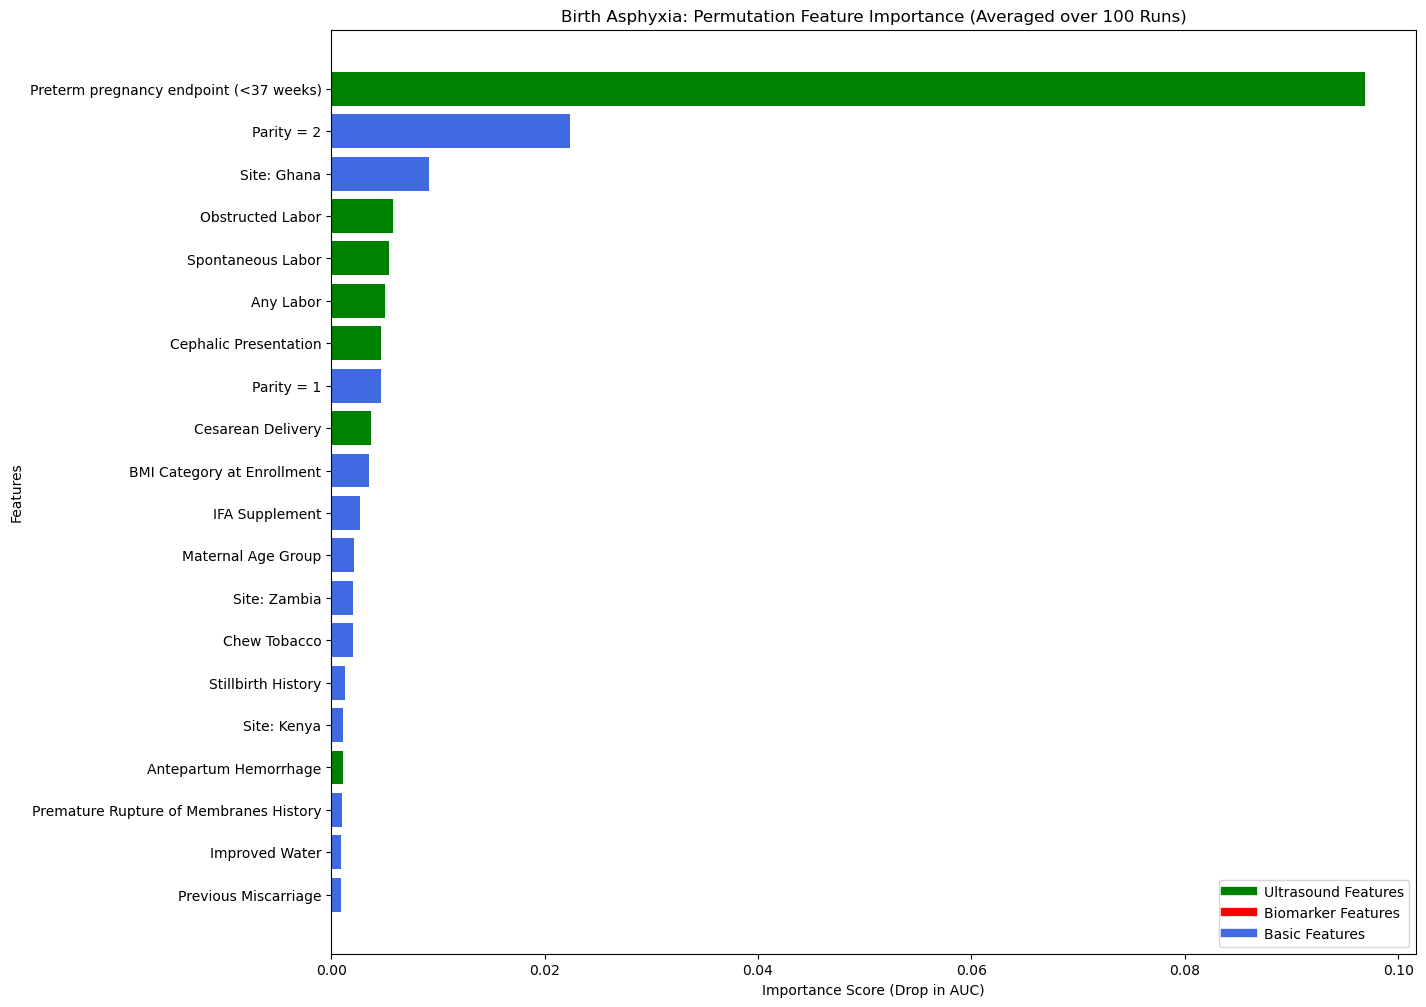

In [2]:
PFI_results('INF_ASPH',"Birth Asphyxia")

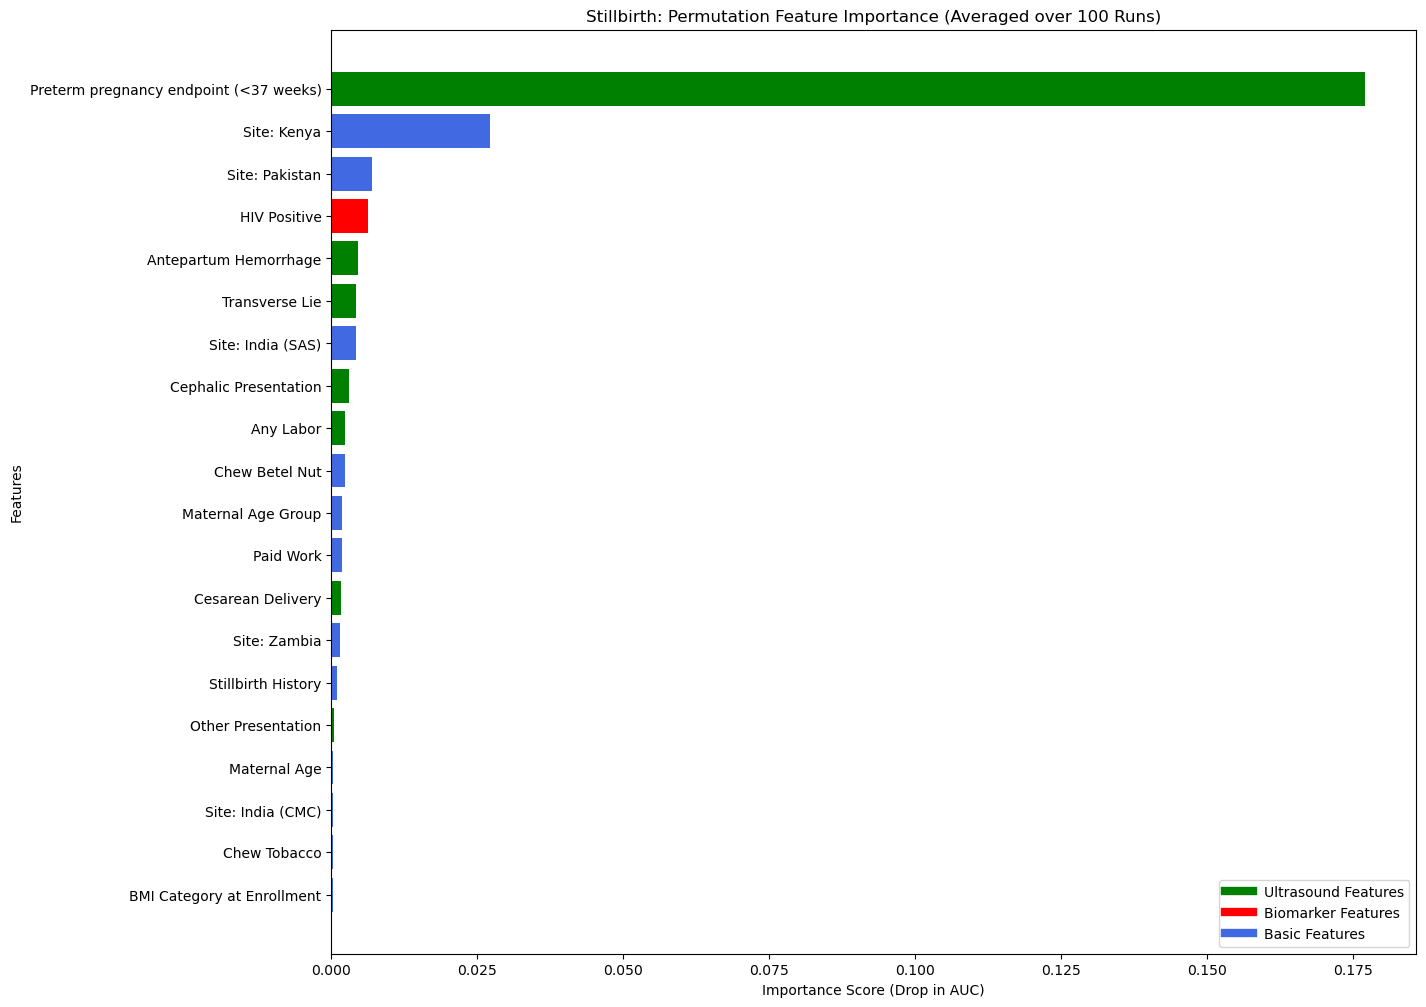

In [3]:
PFI_results('STILLBIRTH_SIGNS_LIFE',"Stillbirth")

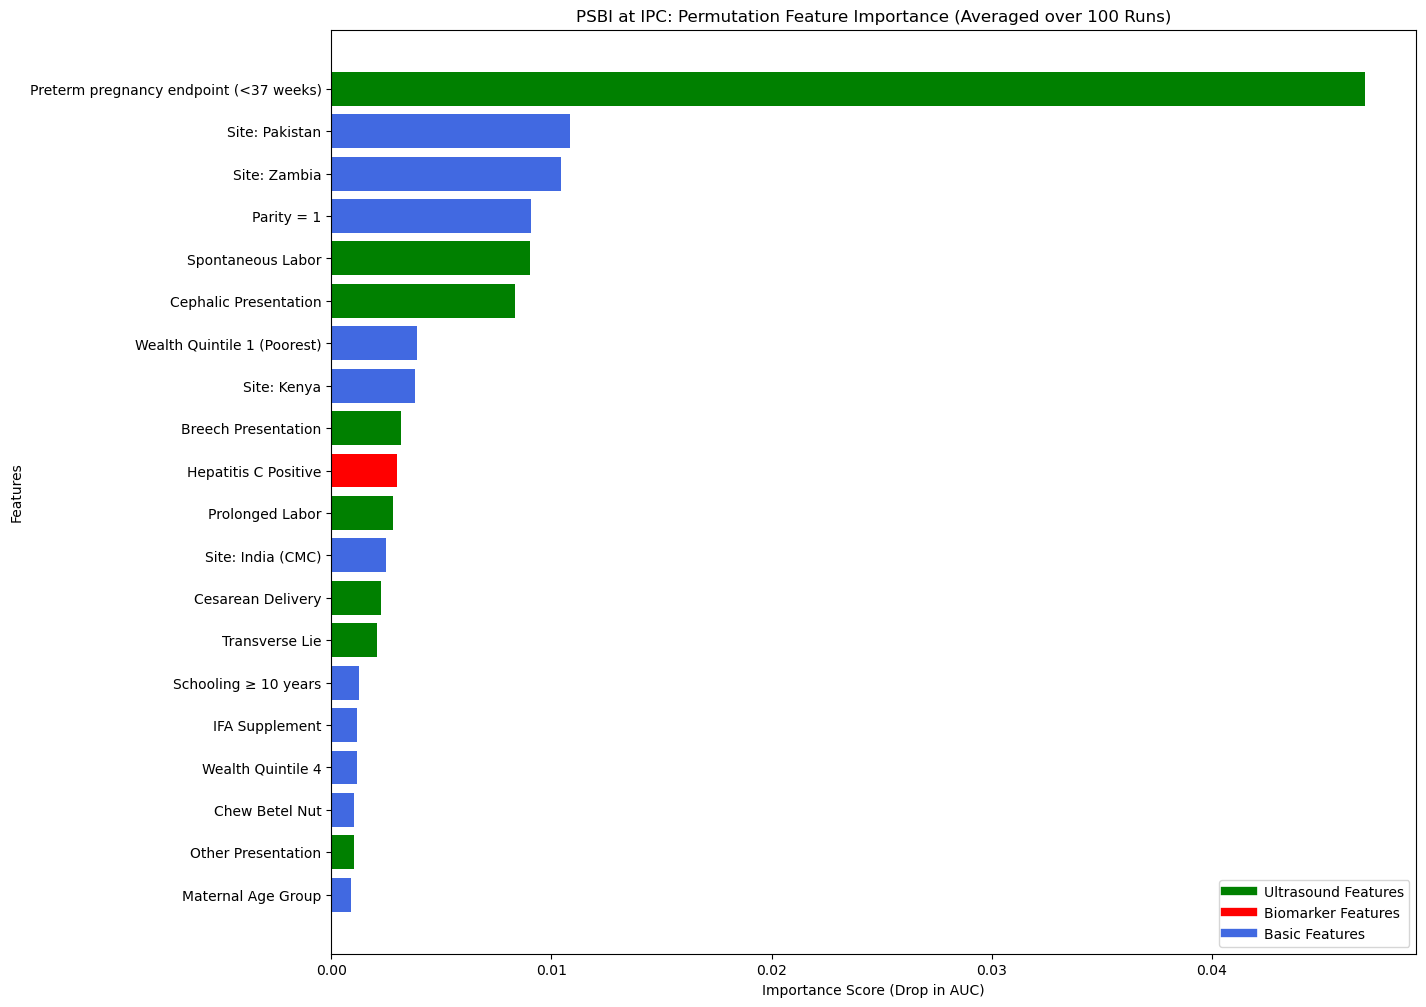

In [4]:
PFI_results('INF_PSBI_IPC',"PSBI at IPC")

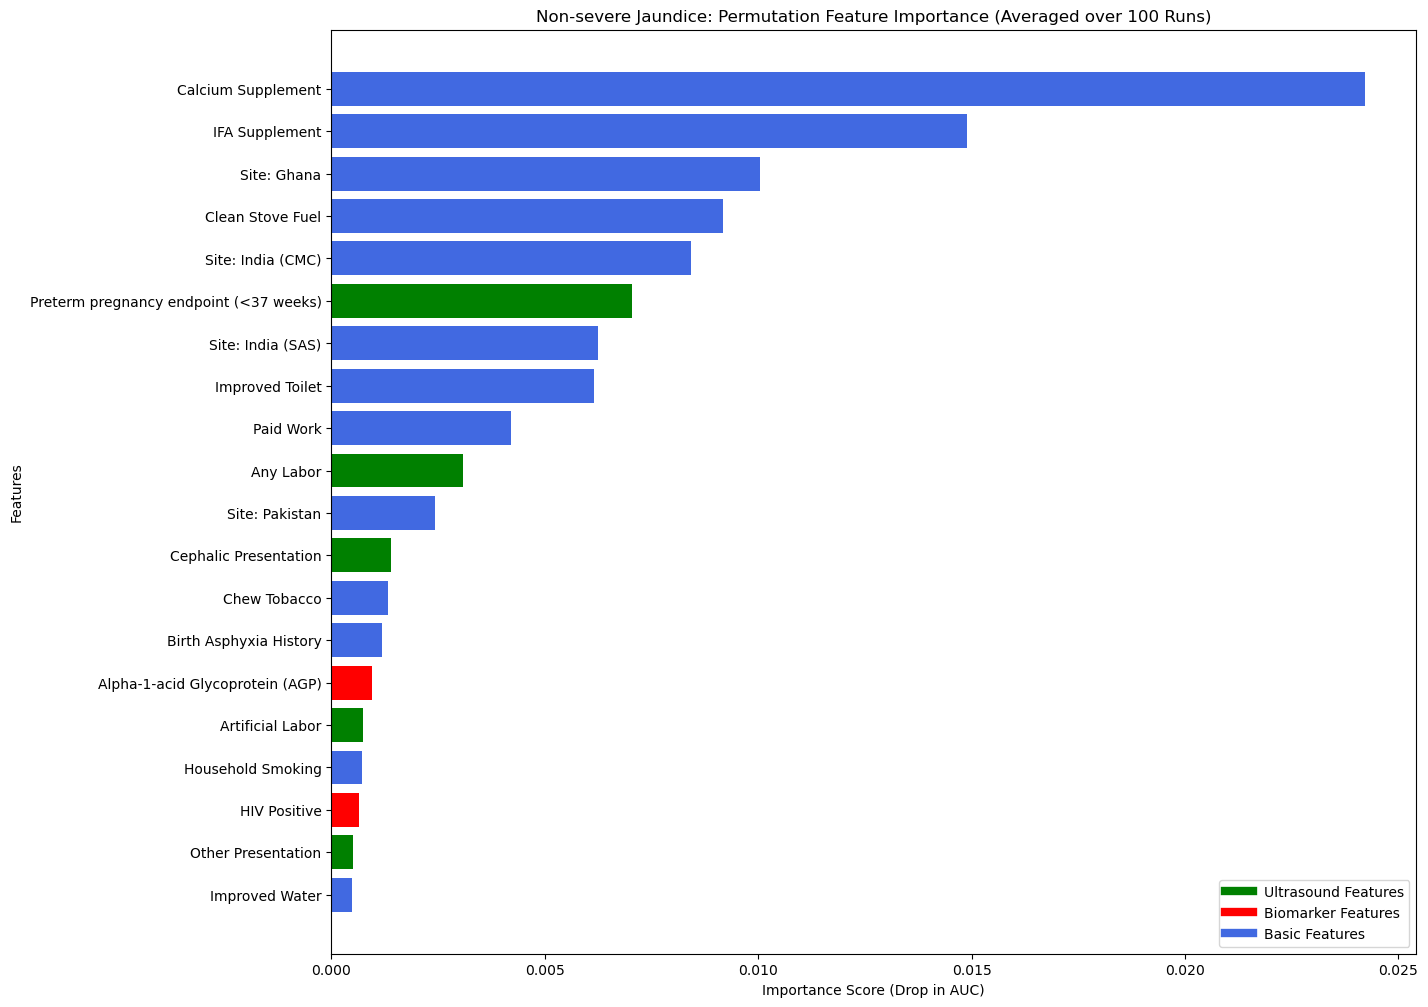

In [5]:
PFI_results('INF_JAUN_NON_SEV_ANY',"Non-severe Jaundice")